In [14]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.annotation.ggs import GreedyGaussianSegmentation
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import os

def load_data(data_dir='../data/raw', columns_to_load=None, date_parse_columns=['date']):
    """
    Load all CSV files from the specified directory and returns a list of dataframes
    ---
    Returns:
        dataframes: a list of dataframes; each dataframe is a patient's data loaded from the csv files
    """
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(os.path.join(data_dir, file), usecols=columns_to_load, parse_dates=date_parse_columns)
        # df['patient_id'] = file.split('_')[0]  # Extract patient ID from filename
        dataframes.append(df)
    
    # combined_df = pd.concat(dataframes, ignore_index=True, axis=0)
    # combined_df = dataframes[0]
    print(f"Loaded data from {len(csv_files)} files.")
    return dataframes

def preprocess_data(df):
    """
    Preprocess the combined DataFrame.
    ---
    1. Fill NaN values with 0
    2. Replace 0 with 'NULL' in the 'msg_type' column
    3. One hot encode the 'msg_type' column
    4. Drop irrelevant columns for the target variable 
    (in this case, only keeps 'ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN')
    5. Drop rows with invalid dates
    6. Change affects_fob and affects_iob to 1 and 0
    """
    df = df.fillna(0)
    df['msg_type'] = df['msg_type'].replace(0, 'NULL')

    # Convert 'date' column to datetime with a custom format
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
    
    # Drop rows where the date is null or invalid
    df = df.dropna(subset=['date'])
    
    # Sort by date and handle duplicate timestamps
    df = df.sort_values('date')
    
    # Set 'date' as the index
    df.set_index('date', inplace=True)
    # Change affects_fob and affects_iob to 1 and 0
    df['affects_fob'] = df['affects_fob'].apply(lambda x: 1 if x != 0 else 0)
    df['affects_iob'] = df['affects_iob'].apply(lambda x: 1 if x != 0 else 0)

    RELEVANT_MSG_TYPES = ['ANNOUNCE_MEAL', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN']
    
    encoder = OneHotEncoder(categories='auto', sparse_output=False)
    encoded_data = encoder.fit_transform(df[['msg_type']])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['msg_type']), index=df.index)
    
    df = df.drop(columns=['msg_type'])
    df = pd.concat([df, encoded_df], axis=1)
    
    COLUMNS_TO_DROP = [col for col in df.columns if 'msg_type' in col and not any(msg_type in col for msg_type in RELEVANT_MSG_TYPES)]
    df.drop(columns=COLUMNS_TO_DROP, inplace=True)
    
    return df


# Version 1: Unsupervised
The version below is unsupervised. That is, it is not trained to segment the data in a particular way.
The meal annotation plus 2 hours dataset is NOT used. The standard GGS algorithm is applied to the entire dataset (individually to each patient's data)


In [54]:
def greedy_gaussian_segmentation(df):
    """
    Perform greedy Gaussian segmentation on the DataFrame using sktime's GreedyGaussianSegmentation.
    ---
    df: a dataframe; each row is a timestamp and each column is a feature
    ---
    Returns:
        segmentation: of shape (n_samples, ) where n_samples is the number of samples in X_nested
        each entry in segmentation is an integer indicating the segment number
        X_nested: the time series data
    """
    # Separate X and y
    X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col])
    # X = df.drop(columns=[col for col in df.columns if col != 'bgl'])

    # Ensure X is not empty
    if X.empty:
        raise ValueError("X is empty after dropping columns. Check your column names and filtering.")

    # Convert X to the required format for sktime
    X_2d = X.values
    X_nested = X

    # X_nested = from_2d_array_to_nested(X_2d, index=X.index)

    # Ensure X_nested is not empty and has the correct shape
    if X_nested.empty or X_nested.shape[1] == 0:
        raise ValueError("X_nested is empty or has no columns. Check the conversion process.")

    # Initialize and fit the segmentation model
    segmenter = GreedyGaussianSegmentation(k_max=10, verbose=True)  # Adjust k_max as needed
    
    # Fit the model
    print("Beginning to fit the GGS Model...")
    try:
        segmenter.fit(X_nested)
        segmentation = segmenter.predict(X_nested.to_numpy())
    except Exception as e:
        print(f"Error during fitting: {e}")
        print(f"X_nested shape: {X_nested.shape}")
        print(f"X_nested dtypes: {X_nested.dtypes}")
        raise

    return segmentation, X_nested



In [25]:
def visualize_segmentation(X_nested, segmentation, column_name='bgl'):
    '''
    Visualize the segmented time series data
    ---
    X_nested: the time series data
    segmentation: of shape (n_samples, ) where n_samples is the number of samples in X_nested
        each entry in segmentation is an integer indicating the segment number
    column_name: the name of the column to plot
    '''
    plt.figure(figsize=(15, 8))
    
    # plot the time series
    plt.plot(X_nested.index, X_nested[column_name].values.flatten(), label=column_name)
    
    # plot segmentation
    unique_segments = np.unique(segmentation)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))
    
    for segment, color in zip(unique_segments, colors):
        mask = segmentation == segment
        plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
                    alpha=0.2, color=color, label=f'Segment {segment}')
    
    plt.title(f'{column_name} Over Time with Segmentation')
    plt.xlabel('Time')
    plt.ylabel(column_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# segmentation.shape
# visualize_segmentation(X_nested, segmentation)

Loaded data from 2 files.


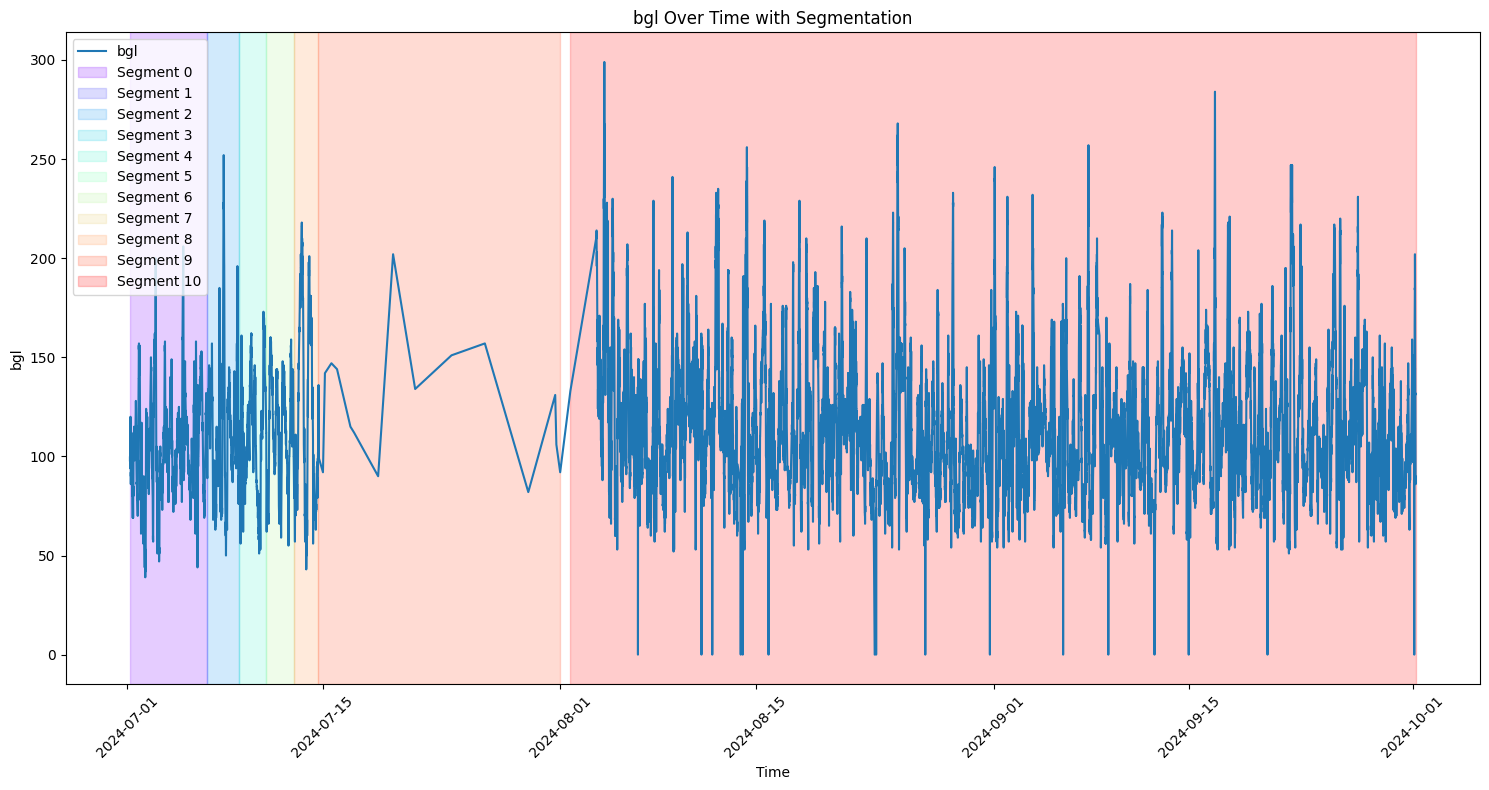

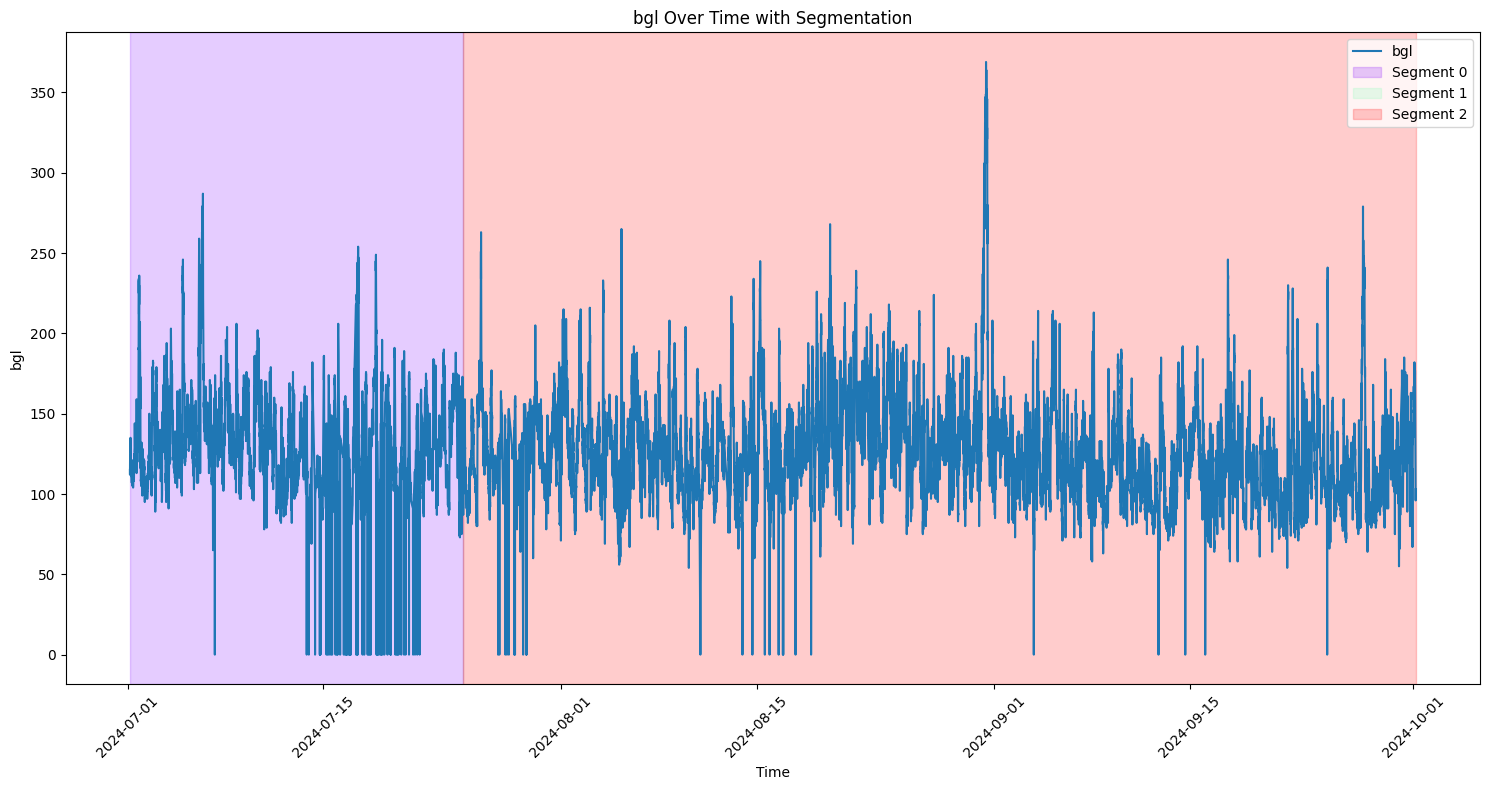

In [56]:
dataframes = load_data(columns_to_load = ['date', 'bgl', 'msg_type', 'affects_fob', 'affects_iob', 'dose_units', 'food_g', 'food_glycemic_index'])
for df in dataframes:
    df = preprocess_data(df)
    segmentation, X_nested = greedy_gaussian_segmentation(df)
    visualize_segmentation(X_nested, segmentation)

# Version 2: Supervised
This version is supervised. That is, it is trained to segment the data in a particular way.
The meal annotation plus 2 hours dataset is used. The standard GGS algorithm is applied to the entire dataset (individually to each patient's data)
The goal of this model is to segment the data around meal times.


In [24]:
df = pd.read_csv("../data/interim/meal_annotation_plus_2hr_meal.csv", parse_dates=['day_4am'])

# Sort the dataframe by date and reset the index
df = df.sort_values('day_4am').reset_index(drop=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Handle NaN values
df['bgl'] = df['bgl'].fillna(method='ffill')  # Forward fill for blood glucose levels
df['dose_units'] = df['dose_units'].fillna(0)  # Fill NaN dose units with 0
df['food_g'] = df['food_g'].fillna(0)  # Fill NaN food grams with 0

# Create a function to generate labels for meal segments
def create_meal_labels(df):
    labels = np.zeros(len(df))
    meal_start = df['msg_type'] == 'ANNOUNCE_MEAL'
    meal_end = df['msg_type'] == 'MEAL_END'
    
    # Mark the start of each meal segment
    labels[meal_start] = 1
    
    # Propagate the meal segment until the next MEAL_END or ANNOUNCE_MEAL
    for i in range(1, len(df)):
        if labels[i] == 0 and labels[i-1] == 1 and not meal_end.iloc[i] and not meal_start.iloc[i]:
            labels[i] = 1
    
    return labels

# Generate meal segment labels
meal_labels = create_meal_labels(df)

# Create a new column for the meal segment labels
df['meal_segment'] = meal_labels

# Modify the greedy_gaussian_segmentation function to support supervised learning
def greedy_gaussian_segmentation(df, supervised=False, label_column=None):
    """
    Perform greedy Gaussian segmentation on the DataFrame using sktime's GreedyGaussianSegmentation.
    ---
    df: a dataframe; each row is a timestamp and each column is a feature
    supervised: boolean, whether to use supervised learning
    label_column: string, name of the column containing labels for supervised learning
    ---
    Returns:
        segmentation: of shape (n_samples, ) where n_samples is the number of samples in X_nested
        each entry in segmentation is an integer indicating the segment number
        X_nested: the time series data
    """
    # Separate X and y
    if supervised and label_column:
        X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col or col == label_column])
        y = df[label_column]
    else:
        X = df.drop(columns=[col for col in df.columns if 'msg_type' in col or 'patient_id' in col])
        y = None

    # Ensure X is not empty
    if X.empty:
        raise ValueError("X is empty after dropping columns. Check your column names and filtering.")

    # Convert X to the required format for sktime
    X_nested = X.set_index('day_4am')

    # Initialize and fit the segmentation model
    segmenter = GreedyGaussianSegmentation(k_max=10, verbose=True)  # Adjust k_max as needed
    
    # Fit the model
    print("Beginning to fit the GGS Model...")
    try:
        if supervised and y is not None:
            segmenter.fit(X_nested, y)
        else:
            segmenter.fit(X_nested)
        segmentation = segmenter.predict(X_nested)
    except Exception as e:
        print(f"Error during fitting: {e}")
        print(f"X_nested shape: {X_nested.shape}")
        print(f"X_nested dtypes: {X_nested.dtypes}")
        raise

    return segmentation, X_nested

# Apply supervised GGS
supervised_segmentation, X_nested = greedy_gaussian_segmentation(df, supervised=True, label_column='meal_segment')

# Display the first few rows of the segmentation result
# print(supervised_segmentation.head())



C:\Users\viloh\AppData\Local\Temp\ipykernel_29212\4146480518.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['bgl'] = df['bgl'].fillna(method='ffill')  # Forward fill for blood glucose levels


Beginning to fit the GGS Model...


AttributeError: 'numpy.ndarray' object has no attribute 'head'

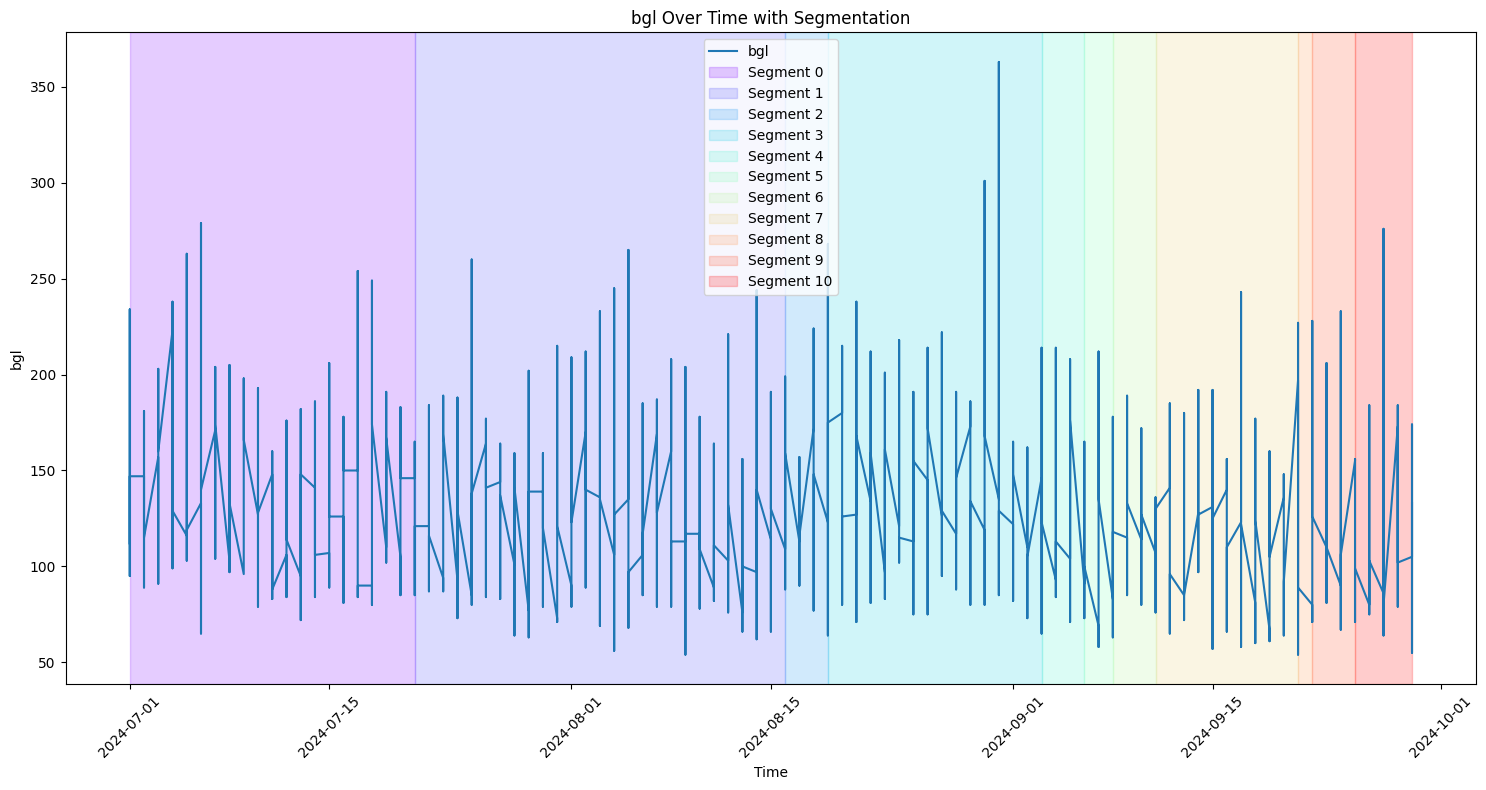

In [26]:
# Visualize the results
visualize_segmentation(X_nested[['bgl']], supervised_segmentation, column_name='bgl')